# IMA205 Challenge: Cardiac Pathology Prediction
## Giulia Mannaioli


## 1) Introduction

Analysis of cardiac function is essential in clinical cardiology for disease diagnosis, patient management and therapy decision. The challenge focuses on four cardiac pathologies that might go unnoticed at first, but can ultimately become life-threatening. Complications include heart failure and sudden cardiac arrest.

It is important to identify these conditions as early as possible to guide treatment and prevent complications. This is why several approaches for automatic diagnosis from cardiac magnetic resonance imaging (CMRI) have been proposed in the last years (non-invasive computer-aided diagnosis (CAD)).

The goal of this challenge is to classify MRI images of the heart among five different diagnostic classes:

1. Healthy controls
2. Myocardial infarction
3. Dilated cardiomyopathy
4. Hypertrophic cardiomyopathy
5. Abnormal right ventricle




## 1) Libraries

In [78]:
import numpy as np
import nibabel as nib
import matplotlib as plt 
import pandas as pd
import os
import matplotlib.pyplot as plt
!pip install scikit-image
!pip install opencv-python
import cv2
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy import ndimage

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from sklearn import decomposition


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: C:\Users\user\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: C:\Users\user\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## 2) Dataset

The dataset of 150 subjects with their MRI images will be utilized, along with their corresponding segmentations and metadata (subject height and weight) when available. The dataset has already been randomly splitted into a training-validation set (consisting of two-thirds of the dataset) and a test set (consisting of one-third of the dataset).


In [79]:
# Directory paths
file_path = ''
train_path = os.path.join(file_path, 'Train')
test_path = os.path.join(file_path, 'Test')

# Load metadata
metadata_train = pd.read_csv(os.path.join(file_path, 'metaDataTrain.csv'))
metadata_test = pd.read_csv(os.path.join(file_path, 'metaDataTest.csv'))


## 3) Features extraction

The class labels ("Category" field in the metadata) are mapped thusly to diagnostic classes:

'0' - Healthy control

'1' - Myocardial infarction

'2' - Dilated cardiomyopathy

'3' - Hypertrophic cardiomyopathy

'4' - Abnormal right ventricle


For each subject, two MRI images are provided : one image at end diastole (end of dilation in the cardiac cycle) and one image at end systole (end of contraction). Each MRI image is a 3D volume containing the heart and adjacent structures. Comparing the cardiac anatomy between these two time points should help you classify subjects.

To help you achieve your goal, you are provided for each image in the training-validation set with a corresponding 3D segmentation of the cardiac anatomy in three substructures: left ventricle cavity, right ventricle cavity, and myocardium (cardiac muscle). Each segmentation map consists in a 3D multi-label mask with the corresponding labels:
0 - Background
1 - Right ventricle cavity
2 - Myocardium
3 - Left ventricle cavity

You can use these segmentations to extract relevant features about the subject's cardiac anatomy. In the test set, you are only given partial segmentations.

- **LV, RV** at ED and ES

- **myocardial volume** at ED and ES (in ml)

- **LV and RV ejection fraction** (EF)

- **ratio between RV and LV volume** at ED and ES

- **ratio between myocardial and LV volume** at ED and ES

- **center of mass of the 3 (difference between s and d)**



Hence, 20 features were used in total: 2 patient-based and 18 image-based features.

articolo: https://link.springer.com/chapter/10.1007/978-3-319-75541-0_11#Sec2


Hence, 20 features were used in total: 2 patient-based and 18 image-based features.

In [80]:
# Initialize lists to store volume data
dtrain = []

#myocardial_density = 1.05
# Loop through each patient folder
for patient in os.listdir(train_path):
    if patient.startswith('.'):
        continue
    
    # Get patient number
    patient_num = patient.split('_')[0]

    # Get height and weight
    metadata_patient = metadata_train[metadata_train['Id'] == int(patient_num)]
    
    height = metadata_patient['Height'].iloc[0]
    weight = metadata_patient['Weight'].iloc[0]
    
    category = metadata_patient['Category'].iloc[0]

    
    # Load ED and ES segmented images
    ed_img = nib.load(os.path.join(train_path, patient, f'{patient_num}_ED.nii'))
    es_img = nib.load(os.path.join(train_path, patient, f'{patient_num}_ES.nii'))
    ed_seg_img = nib.load(os.path.join(train_path, patient, f'{patient_num}_ED_seg.nii'))
    es_seg_img = nib.load(os.path.join(train_path, patient, f'{patient_num}_ES_seg.nii'))



    # Calculate ED and ES volumes for each segmented structure
    ed_RV = np.sum(ed_seg_img.get_fdata() == 1)  * np.prod(ed_img.header.get_zooms()) *0.001
    ed_my = np.sum(ed_seg_img.get_fdata() == 2)  * np.prod(ed_img.header.get_zooms()) *0.001
    ed_LV = np.sum(ed_seg_img.get_fdata() == 3)  * np.prod(ed_img.header.get_zooms()) *0.001
    es_RV = np.sum(es_seg_img.get_fdata() == 1)  * np.prod(es_img.header.get_zooms()) *0.001
    es_my = np.sum(es_seg_img.get_fdata() == 2)  * np.prod(es_img.header.get_zooms()) *0.001
    es_LV = np.sum(es_seg_img.get_fdata() == 3)  * np.prod(es_img.header.get_zooms()) *0.001


    if (ed_LV - es_LV) == 0 or ed_LV == 0:
        EF_LV = 0
    else:
        EF_LV = (ed_LV - es_LV) / ed_LV

    if (ed_RV - es_RV) == 0 or ed_RV == 0:
        EF_RV = 0
    else:
        EF_RV = (ed_RV - es_RV) / ed_RV

    if ed_RV == 0 or ed_LV == 0:
        ed_ratio_vol = 0
    else:
        ed_ratio_vol = ed_RV / ed_LV

    if es_RV == 0 or es_LV == 0:
        es_ratio_vol = 0
    else:
        es_ratio_vol = es_RV / es_LV

    if ed_my == 0 or ed_LV == 0:
        ed_ratio_my = 0
    else:
        ed_ratio_my = ed_my / ed_LV

    if es_my == 0 or es_LV == 0:
        es_ratio_my = 0
    else:
        es_ratio_my = es_my / es_LV


    #compute centro di massa
    ed_cmRV = ndimage.center_of_mass(ed_seg_img.get_fdata() == 1)

    es_cmRV = ndimage.center_of_mass(es_seg_img.get_fdata() == 1)

    ed_cmMY = ndimage.center_of_mass(ed_seg_img.get_fdata() == 2)

    es_cmMY = ndimage.center_of_mass(es_seg_img.get_fdata() == 2)
    
    ed_cmLV = ndimage.center_of_mass(ed_seg_img.get_fdata() == 3)

    es_cmLV = ndimage.center_of_mass(es_seg_img.get_fdata() == 3)
    
    if(es_my == 0):
        cmMY = (0.0,0.0,0.0)
    else:
        cmMY = (ed_cmMY[0]-es_cmMY[0], ed_cmMY[1]-es_cmMY[1],ed_cmMY[2]-es_cmMY[2])

    cmLV = (ed_cmLV[0]-es_cmLV[0], ed_cmLV[1]-es_cmLV[1],ed_cmLV[2]-es_cmLV[2])
    cmRV = (ed_cmRV[0]-es_cmRV[0], ed_cmRV[1]-es_cmRV[1],ed_cmRV[2]-es_cmRV[2])
    
    # Append volumes to lists
    dtrain.append([category, height, weight,ed_RV,ed_my,ed_LV,es_RV,
                                    es_my,es_LV,EF_LV,EF_RV,ed_ratio_vol, es_ratio_vol,ed_ratio_my,es_ratio_my, cmLV[0],cmLV[1],cmLV[2], cmRV[0],cmRV[1],cmRV[2],cmMY[0],cmMY[1], cmMY[2]])



#ED_my_mass = (ed_my.sum())  * myocardial_density
#
#ES_my_mass = (es_my.sum())  * myocardial_density

                                    #   [category,      height, weight, ed_RV,      ed_my,   ed_LV,   es_RV,  es_my,    es_LV,  EF_LV,  EF_RV,  ed_ratio_vol,  es_ratio_vol,   ed_ratio_my,  es_ratio_my])
dataTrain = pd.DataFrame(dtrain, columns=['Category', 'Height', 'Weight', 'ED_RV', 'ED_My', 'ED_LV', 'ES_RV', 'ES_My', 'ES_LV', 'EF_LV','EF_RV', 'ed_ratio_vol','es_ratio_vol','ed_ratio_my',
                                                'es_ratio_my','XcmLV','YcmLV','ZcmLV','XcmRV','YcmRV','ZcmRV','XcmMY','YcmMY','ZcmMY'])

In [81]:
dataTrain

,Category,Height,Weight,ED_RV,ED_My,ED_LV,ES_RV,ES_My,ES_LV,EF_LV,...,es_ratio_my,XcmLV,YcmLV,ZcmLV,XcmRV,YcmRV,ZcmRV,XcmMY,YcmMY,ZcmMY
0,2,184.0,95.0,139.721680,164.257812,295.507812,59.545898,195.068359,225.610352,0.236533,...,0.864625,2.335208,-1.811695,-0.010676,-1.275576,0.783472,-0.280273,0.862977,-1.377368,-0.349549
1,2,160.0,70.0,94.432068,160.433578,265.744400,28.823090,192.565155,188.303375,0.291412,...,1.022633,1.598911,-1.650472,-0.143883,-2.375318,2.914811,-0.347194,-0.773916,0.748292,-0.105268
2,2,165.0,77.0,192.333984,191.845703,276.708984,174.584961,201.074219,241.088867,0.128728,...,0.834025,0.088159,0.676850,-0.045592,-2.648428,-0.003840,-0.134127,-0.567056,-0.370836,-0.062136
3,2,159.0,46.0,106.264114,168.452454,260.847092,84.543991,174.957275,226.472473,0.131781,...,0.772532,1.145440,-1.252195,-0.053626,-0.489262,3.651263,-0.022517,-0.192708,-0.373813,-0.126392
4,2,165.0,77.0,170.463867,201.392578,290.797119,74.553223,232.261963,224.094727,0.229378,...,1.036445,2.159917,4.195679,-0.273377,1.920662,1.063479,0.017905,-0.025404,2.251053,-0.172413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,4,186.0,76.0,284.093104,116.967022,152.260992,217.681545,115.055796,74.905896,0.508043,...,1.536005,0.758746,-0.474550,0.159539,-1.473442,-0.468569,-0.742648,0.816248,-0.262128,-0.714280
96,4,187.0,82.0,208.836737,93.511618,124.381028,129.096270,110.345472,49.664276,0.600709,...,2.221828,1.081239,0.418261,0.253551,-1.730370,1.542456,-0.520394,-0.335648,-0.388146,-0.181450
97,4,167.0,50.0,164.656250,93.625000,93.843750,161.500000,102.171875,41.187500,0.561106,...,2.480653,0.035140,0.794836,0.597566,-1.572307,2.809218,-0.084851,-0.795559,0.864686,-0.108200
98,4,180.0,80.0,200.365734,92.585646,140.401103,136.638366,92.234883,74.058951,0.472519,...,1.245425,0.402463,-1.130469,-0.677002,-2.888961,0.139476,-1.606384,-0.424818,-0.934042,-0.324849


## 4) Segmentation

Attempts not succeded or not efficient.

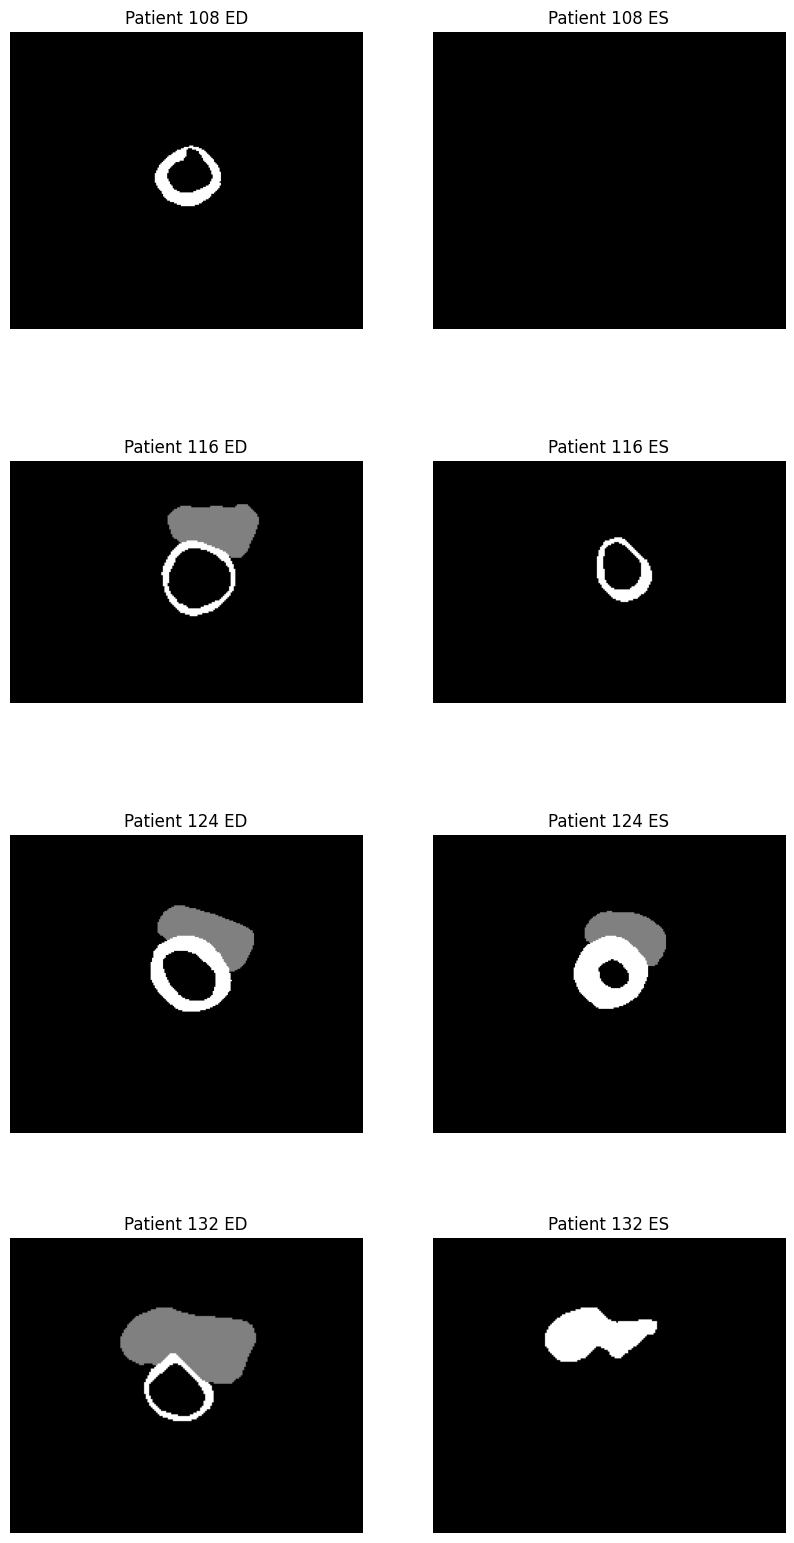

In [82]:
# Define the number of images to plot
num_images = 4

# Create subplots for ED segmented images
fig, axs = plt.subplots(num_images, 2, figsize=(10, 20))
for i, patient in enumerate(os.listdir(test_path)[7:32:8]):
    ed_seg_img = nib.load(os.path.join(test_path, patient, f'{patient.split("_")[0]}_ED_seg.nii'))
    axs[i, 0].imshow(ed_seg_img.get_fdata()[:, :, 2], cmap='gray')
    axs[i, 0].axis('off')
    axs[i, 0].set_title(f'Patient {patient.split("_")[0]} ED')

# Create subplots for ES segmented images
for i, patient in enumerate(os.listdir(test_path)[7:32:8]):
    es_seg_img = nib.load(os.path.join(test_path, patient, f'{patient.split("_")[0]}_ES_seg.nii'))
    axs[i, 1].imshow(es_seg_img.get_fdata()[:, :, 2], cmap='gray')
    axs[i, 1].axis('off')
    axs[i, 1].set_title(f'Patient {patient.split("_")[0]} ES')


plt.show()


In [83]:
import skimage.segmentation
from skimage import exposure
from skimage import segmentation
from skimage.color import rgb2gray

def segment132(img):
    img = img.get_fdata()[:, :, 2].copy()

    threshold_value = 80  # Valore della soglia
    max_value = 255  # Valore massimo assegnato ai pixel sopra la soglia
    ret, img_to_seg = cv2.threshold(img, threshold_value, max_value, cv2.THRESH_BINARY)
    img_to_seg = skimage.morphology.diameter_closing(img_to_seg, 40, connectivity=3)

    seed = (80,100)
    RV = segmentation.flood(img_to_seg, seed, tolerance=0, connectivity=1)
    seed = (60,100)
    LV = segmentation.flood(img_to_seg, seed, tolerance=0, connectivity=0.5)
    LV = skimage.morphology.binary_erosion(LV, skimage.morphology.square(3))
    LV = skimage.morphology.binary_dilation(LV, skimage.morphology.square(3))

    mask_LV = np.where(LV == 1, 1, 0)
    mask_RV = np.where(RV == 1, 3, 0)

    
    es_seg_img=mask_RV+mask_LV

    return es_seg_img


def segment108es(img):
    
    img = img.get_fdata()[:, :, 2].copy()
    threshold_value = 200  # Valore della soglia
    max_value = 255  # Valore massimo assegnato ai pixel sopra la soglia
    ret, img_to_seg = cv2.threshold(img, threshold_value, max_value, cv2.THRESH_BINARY)
    img_to_seg = skimage.morphology.diameter_closing(img_to_seg, 40, connectivity=3)


    seed = (75,118)
    RV = segmentation.flood(img_to_seg, seed, tolerance=0, connectivity=0.1)


    mask_region = [slice(50, 150), slice(120,144)]  
    img_masked = np.zeros_like(RV)  
    img_masked[mask_region] = RV[mask_region]  

    img_masked = skimage.morphology.binary_erosion(img_masked, skimage.morphology.square(5))
    img_masked = skimage.morphology.binary_dilation(img_masked, skimage.morphology.square(5))

    mask_regionLV = [slice(50, 150), slice(90,123)]
    img_maskedLV1 = np.zeros_like(RV)  
    img_maskedLV1[mask_regionLV] = RV[mask_regionLV]

    mask_regionLV = [slice(50, 95), slice(140,180)]
    img_maskedLV2 = np.zeros_like(RV) 
    img_maskedLV2[mask_regionLV] = RV[mask_regionLV]

    img_maskedLV = img_maskedLV1+img_maskedLV2

    img_maskedLV = skimage.morphology.binary_erosion(img_maskedLV, skimage.morphology.square(5))
    img_maskedLV = skimage.morphology.binary_dilation(img_maskedLV, skimage.morphology.square(5))

    img_maskedLV = np.where(img_maskedLV == 1, 1, 0)
    img_masked = np.where(img_masked == 1, 3, 0)

    es_seg_img=img_maskedLV+img_masked

    return es_seg_img

def segment108ed(img):
    
    img = img.get_fdata()[:, :, 2].copy()
    threshold_value = 200  # Valore della soglia
    max_value = 255  # Valore massimo assegnato ai pixel sopra la soglia
    ret, img_to_seg = cv2.threshold(img, threshold_value, max_value, cv2.THRESH_BINARY)
    img_to_seg = skimage.morphology.diameter_closing(img_to_seg, 40, connectivity=3)


    seed = (75,118)
    RV = segmentation.flood(img_to_seg, seed, tolerance=0, connectivity=0.1)

    seed2 = (100,126)
    RV2 = segmentation.flood(img_to_seg, seed2, tolerance=0, connectivity=0.1)

    RV2 = skimage.morphology.binary_erosion(RV2, skimage.morphology.square(5))


    mask_regionRV = [slice(40, 100), slice(140,200)]
    img_maskedRV = np.zeros_like(RV)  
    img_maskedRV[mask_regionRV] = RV2[mask_regionRV]


    img_maskedRV = skimage.morphology.binary_erosion(img_maskedRV, skimage.morphology.square(3))
    img_maskedRV = skimage.morphology.binary_dilation(img_maskedRV, skimage.morphology.square(7))


    ed_seg_img=img_maskedRV+RV

    ed_seg_img = np.where(ed_seg_img == 1, 1, 0)


    return ed_seg_img

def segment116(img):
    
    img = img.get_fdata()[:, :, 2].copy()


    # Get the image to segment
    threshold_value = 75  # Valore della soglia
    max_value = 255  # Valore massimo assegnato ai pixel sopra la soglia
    ret, img_to_seg = cv2.threshold(img, threshold_value, max_value, cv2.THRESH_BINARY)
    img_to_seg = skimage.morphology.diameter_closing(img_to_seg, 40, connectivity=3)


    seed = (40,130)
    es_seg_img = segmentation.flood(img_to_seg, seed, tolerance=0, connectivity=3)

    

    es_seg_img = np.where(es_seg_img == 1, 1, 0)



    return es_seg_img


C:\Users\user\AppData\Local\Temp\ipykernel_19956\2833661154.py:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  img_masked[mask_region] = RV[mask_region]
C:\Users\user\AppData\Local\Temp\ipykernel_19956\2833661154.py:58: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  img_maskedLV1[mask_regionLV] = RV[mask_regionLV]
C:\Users\user\AppData\Local\Temp\ipykernel_19956\2833661154.py:62: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be i

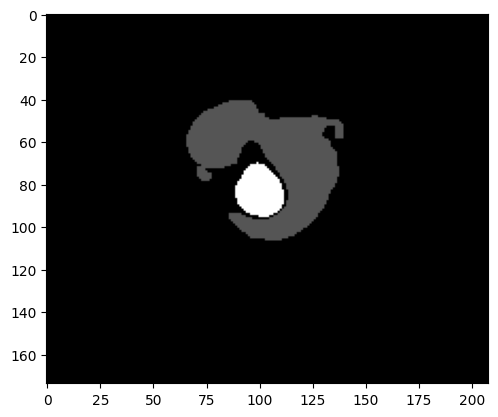

In [84]:
# Initialize lists to store volume data


dTest = []
myocardial_density=1.05
# Loop through each patient folder
for patient in os.listdir(test_path):
    if patient.startswith('.'):
        continue
    
    # Get patient number
    patient_num = patient.split('_')[0]

    
    # Load ED and ES segmented images
    ed_img = nib.load(os.path.join(test_path, patient, f'{patient_num}_ED.nii'))
    es_img = nib.load(os.path.join(test_path, patient, f'{patient_num}_ES.nii'))
    ed_seg_img = nib.load(os.path.join(test_path, patient, f'{patient_num}_ED_seg.nii'))
    es_seg_img = nib.load(os.path.join(test_path, patient, f'{patient_num}_ES_seg.nii'))
    
    if(patient_num=='132'): #ES! trovato left e right ma no miocardio e devo ignorare la segmentazione
        es_seg_img2 = segment132(es_img)
        plt.imshow(es_seg_img2, cmap="gray");

    elif(patient_num=='108'): #ED ha miocardio, ES NIENTE rimane senza miocaridio ma ho trovato lv e rv
        es_seg_img2 = segment108es(es_img)
        #plt.imshow(es_seg_img2,cmap="gray");
        
    else:
        ##rova la mask finale ES
        mask_es_my_all = es_seg_img.get_fdata()[:, :, 2].copy()
        mask_es_my = (mask_es_my_all==2).astype(np.uint8)
        h, w= mask_es_my.shape
        seed=(0,0)
        mask_ff = np.zeros((h+2,w+2), np.uint8)
        mask_es_my = cv2.floodFill(mask_es_my, mask_ff, seed, 1)[1]
        mask_es_my = np.where(mask_es_my == 1, 0, 3)
        if(patient_num=='116'): #ES  trovato lv ma devo trovare rv con il miocardio che ho
            es_seg_img2 = mask_es_my+segment116(es_img)+es_seg_img.get_fdata()[:, :, 2]

            plt.imshow(es_seg_img2, cmap="gray");
        
        else:
            es_seg_img2 = mask_es_my+es_seg_img.get_fdata()[:, :, 2]
    
    ##rova la mask finale ED
    mask_ed_my_all = ed_seg_img.get_fdata()[:, :, 2].copy()
    mask_ed_my = (mask_ed_my_all==2).astype(np.uint8)
    h, w= mask_ed_my.shape
    seed=(0,0)
    mask_ff = np.zeros((h+2,w+2), np.uint8)
    mask_ed_my = cv2.floodFill(mask_ed_my, mask_ff, seed, 1)[1]
    mask_ed_my = np.where(mask_ed_my == 1, 0, 3)
    if(patient_num=='108'):
        ed_seg_img2 = mask_ed_my+segment108ed(ed_img)+ed_seg_img.get_fdata()[:, :, 2]
    else:
        ed_seg_img2 = mask_ed_my+ed_seg_img.get_fdata()[:, :, 2]

## 5) Classification



### Validation set

In [85]:
X_train, X_val, y_train, y_val = train_test_split(dataTrain[[ 'Height', 'Weight', 'ED_RV', 'ED_My', 'ED_LV', 'ES_RV', 'ES_My', 'ES_LV', 'EF_LV','EF_RV', 'ed_ratio_vol','es_ratio_vol','ed_ratio_my',
                                            'es_ratio_my','XcmLV','YcmLV','ZcmLV','XcmRV','YcmRV','ZcmRV','XcmMY','YcmMY','ZcmMY']], dataTrain["Category"], test_size=0.2, random_state=42)


**Random Forest**

In [86]:
RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}   


grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring='accuracy', cv=5)
grid_RF.fit(X_train, y_train)

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_val,y_val))

Best Validation Score: 0.9125
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 20}
Random Forest test score : 0.95


**Svm non linear**

In [87]:
p_grid_nlsvm = {'C': [0.01,0.001, 10, 1, 100, 200],
                'gamma': [0.001, 0.005]}
NLsvm = SVC(kernel='rbf')
grid_nlsvm = GridSearchCV(NLsvm, param_grid=p_grid_nlsvm, cv=5, scoring='accuracy')
grid_nlsvm.fit(X_train, y_train)

print("Best validation score: {}".format(grid_nlsvm.best_score_))
print("Best params: {}".format(grid_nlsvm.best_params_))
print("Non-linear SVM validation score:", grid_nlsvm.score(X_val, y_val))


Best validation score: 0.75
Best params: {'C': 1, 'gamma': 0.001}
Non-linear SVM validation score: 0.85


### Test set

In [94]:
# Initialize lists to store volume data

dTest = []
#myocardial_density=1.05
# Loop through each patient folder
for patient in os.listdir(test_path):
    if patient.startswith('.'):
        continue
    
    # Get patient number
    patient_num = patient.split('_')[0]

    # Get height and weight
    metadata_patient_test = metadata_test[metadata_test['Id'] == int(patient_num)]
    heightTest = metadata_patient_test['Height'].iloc[0]
    weightTest = metadata_patient_test['Weight'].iloc[0]
    
    
    # Load ED and ES segmented images
    ed_img = nib.load(os.path.join(test_path, patient, f'{patient_num}_ED.nii'))
    es_img = nib.load(os.path.join(test_path, patient, f'{patient_num}_ES.nii'))
    ed_seg_img = nib.load(os.path.join(test_path, patient, f'{patient_num}_ED_seg.nii'))
    es_seg_img = nib.load(os.path.join(test_path, patient, f'{patient_num}_ES_seg.nii'))

    # masked images
    ed_seg_img2_array = np.zeros_like(ed_seg_img.get_fdata())
    es_seg_img2_array = np.zeros_like(es_seg_img.get_fdata())

    # Loop through the images of a patient
    for i in range(ed_seg_img.shape[2]):
        # Extract 2D mask for current img
        mask_ed_my_all = ed_seg_img.get_fdata()[:, :, i].copy()
        mask_ed_my = (mask_ed_my_all==2).astype(np.uint8)
        
        # Apply flood fill to mask
        h, w = mask_ed_my.shape
        seed = (0,0)
        mask_ff = np.zeros((h+2,w+2), np.uint8)
        mask_ed_my = cv2.floodFill(mask_ed_my, mask_ff, seed, 1)[1]
        mask_ed_my = np.where(mask_ed_my == 1, 0, 3)
        
        # Apply mask to current slice and accumulate in array to have the 10 imgs for every patient
        ed_seg_img2_array[:, :, i] = mask_ed_my + ed_seg_img.get_fdata()[:, :, i]

    for i in range(es_seg_img.shape[2]):
        # Extract 2D mask for current img
        mask_es_my_all = es_seg_img.get_fdata()[:, :, i].copy()
        mask_es_my = (mask_es_my_all==2).astype(np.uint8)
        
        # Apply flood fill to mask
        h, w = mask_es_my.shape
        seed = (0,0)
        mask_ff = np.zeros((h+2,w+2), np.uint8)
        mask_es_my = cv2.floodFill(mask_es_my, mask_ff, seed, 1)[1]
        mask_es_my = np.where(mask_es_my == 1, 0, 3)
        
        # Apply mask to current slice and accumulate in array to have the 10 imgs for every patient
        es_seg_img2_array[:, :, i] = mask_es_my + es_seg_img.get_fdata()[:, :, i]

    # new Nifti1Image objects 
    ed_seg_img2 = nib.Nifti1Image(ed_seg_img2_array, ed_seg_img.affine)
    es_seg_img2 = nib.Nifti1Image(es_seg_img2_array, es_seg_img.affine)


    # Calculate ED and ES volumes for each segmented structure
    ed_RV = np.sum(ed_seg_img2.get_fdata() == 1) * np.prod(ed_img.header.get_zooms()) *0.001
    ed_my = np.sum(ed_seg_img2.get_fdata() == 2) * np.prod(ed_img.header.get_zooms()) *0.001
    ed_LV = np.sum(ed_seg_img2.get_fdata() == 3) * np.prod(ed_img.header.get_zooms()) *0.001
    es_RV = np.sum(es_seg_img2.get_fdata() == 1) * np.prod(es_img.header.get_zooms()) *0.001
    es_my = np.sum(es_seg_img2.get_fdata() == 2) * np.prod(es_img.header.get_zooms()) *0.001
    es_LV = np.sum(es_seg_img2.get_fdata() == 3) * np.prod(es_img.header.get_zooms()) *0.001
    
    #just to be sure to not have problems
    if (ed_LV-es_LV) == 0 or ed_LV == 0:
        EF_LV = 0
    else:
        EF_LV = (ed_LV - es_LV) / ed_LV

    if (ed_RV-es_RV) == 0 or ed_RV == 0:
        EF_RV = 0
    else:
        EF_RV = (ed_RV - es_RV) / ed_RV

    if ed_RV == 0 or ed_LV == 0:
        ed_ratio_vol = 0
    else:
        ed_ratio_vol = ed_RV / ed_LV

    if es_RV == 0 or es_LV == 0:
        es_ratio_vol = 0
    else:
        es_ratio_vol = es_RV / es_LV

    if ed_my == 0 or ed_LV == 0:
        ed_ratio_my = 0
    else:
        ed_ratio_my = ed_my / ed_LV

    if es_my == 0 or es_LV == 0:
        es_ratio_my = 0
    else:
        es_ratio_my = es_my / es_LV


    #compute centro di massa
    ed_cmRV = ndimage.center_of_mass(ed_seg_img2.get_fdata() == 1)
 
    es_cmRV = ndimage.center_of_mass(es_seg_img2.get_fdata() == 1)
 
    ed_cmMY = ndimage.center_of_mass(ed_seg_img2.get_fdata() == 2)
 
    es_cmMY = ndimage.center_of_mass(es_seg_img2.get_fdata() == 2)
 
    ed_cmLV = ndimage.center_of_mass(ed_seg_img2.get_fdata() == 3)
 
    es_cmLV = ndimage.center_of_mass(es_seg_img2.get_fdata() == 3)

    if(es_my == 0):
        cmMY = (0.0,0.0,0.0)
    else:
        cmMY = (ed_cmMY[0]-es_cmMY[0], ed_cmMY[1]-es_cmMY[1],ed_cmMY[2]-es_cmMY[2])

    cmRV = (ed_cmRV[0]-es_cmRV[0], ed_cmRV[1]-es_cmRV[1],ed_cmRV[2]-es_cmRV[2])

    cmLV = (ed_cmLV[0]-es_cmLV[0], ed_cmLV[1]-es_cmLV[1],ed_cmLV[2]-es_cmLV[2])


    # Append volumes to lists
    dTest.append([heightTest, weightTest,ed_RV,ed_my,ed_LV,es_RV, 
                                    es_my,es_LV,EF_LV,EF_RV,ed_ratio_vol, es_ratio_vol,ed_ratio_my,es_ratio_my, cmLV[0],cmLV[1],cmLV[2], cmRV[0],cmRV[1],cmRV[2],cmMY[0],cmMY[1], cmMY[2]])


#ED_my_mass = (ed_my.sum())  * myocardial_density
#
#ES_my_mass = (es_my.sum())  * myocardial_density


                            #         patient_num, height, weight,    ed_RV,    ed_my,    ed_LV,  es_RV,  es_my,    es_LV,    EF_LV,  EF_RV,  ed_ratio_vol, es_ratio_vol,   ed_ratio_my,    es_ratio_my
dataTest = pd.DataFrame(dTest, columns=[ 'Height', 'Weight', 'ED_RV', 'ED_My', 'ED_LV', 'ES_RV', 'ES_My', 'ES_LV', 'EF_LV','EF_RV', 'ed_ratio_vol','es_ratio_vol',
                                        'ed_ratio_my','es_ratio_my','XcmLV','YcmLV','ZcmLV','XcmRV','YcmRV','ZcmRV','XcmMY','YcmMY','ZcmMY'])

In [95]:
filtered_data = dataTest.query('ED_My == 0 or ES_My == 0 or ES_LV == 0 or ED_LV == 0 or ES_RV == 0 or ED_RV == 0')
print(filtered_data)

Empty DataFrame
Columns: [Height, Weight, ED_RV, ED_My, ED_LV, ES_RV, ES_My, ES_LV, EF_LV, EF_RV, ed_ratio_vol, es_ratio_vol, ed_ratio_my, es_ratio_my, XcmLV, YcmLV, ZcmLV, XcmRV, YcmRV, ZcmRV, XcmMY, YcmMY, ZcmMY]
Index: []

[0 rows x 23 columns]


In [96]:
dataTest

,Height,Weight,ED_RV,ED_My,ED_LV,ES_RV,ES_My,ES_LV,EF_LV,EF_RV,...,es_ratio_my,XcmLV,YcmLV,ZcmLV,XcmRV,YcmRV,ZcmRV,XcmMY,YcmMY,ZcmMY
0,167.0,89.0,143.329510,153.584635,278.126540,84.921052,149.924013,194.309058,0.301365,0.407512,...,0.771575,1.463695,1.884114,-0.293954,-2.395520,-0.899416,-0.649222,0.278093,-1.187897,-0.642305
1,137.0,35.0,169.334610,42.457528,73.914890,98.704197,43.250333,33.127915,0.551810,0.417106,...,1.305556,3.371749,-2.687180,0.250530,1.534947,0.021062,0.401453,3.388874,-2.882588,-0.589953
2,167.0,116.0,172.412109,113.867188,125.512695,94.458008,128.100586,41.748047,0.667380,0.452138,...,3.068421,1.008700,-0.953349,0.019758,-1.602129,0.835822,-0.525559,0.742591,-0.534067,-0.543287
3,160.0,98.0,147.985239,119.629346,108.058945,55.197728,143.349602,19.925763,0.815603,0.627005,...,7.194184,-0.002774,-4.359986,0.548128,-3.395966,1.882187,-0.882245,1.206741,-2.069264,-0.804418
4,174.0,64.0,222.480845,95.915223,121.780479,167.480013,108.033810,50.810293,0.582771,0.247216,...,2.126219,0.706144,2.324709,0.599682,-1.567881,1.147626,0.564227,0.422486,2.149214,-0.700953
5,175.0,107.0,88.891602,173.754883,178.173828,34.130859,174.365234,131.762695,0.260482,0.616040,...,1.323328,5.556498,-1.986792,-0.723476,-0.804964,-0.986736,-0.819242,2.795009,-0.695425,0.247548
6,175.0,75.0,141.090939,84.235509,143.200366,75.061625,87.619087,52.310959,0.634701,0.467991,...,1.674966,0.271879,-1.093590,-0.454418,-1.667667,2.383479,-0.919371,1.237134,-1.343369,-1.076582
7,185.0,104.0,138.266159,118.024445,111.110092,75.598312,132.354492,41.987457,0.622109,0.453241,...,3.152239,1.605464,-0.703165,-0.210497,-1.840315,-0.577363,-0.362651,1.363218,-0.558416,-0.713589
8,172.0,104.0,309.319750,103.910337,122.085227,162.956124,134.322384,33.878236,0.722503,0.473179,...,3.964858,3.384496,0.472837,1.603231,-2.534516,0.454361,-0.932622,0.694766,0.941473,0.089520
9,162.0,60.0,233.212025,81.517322,137.339273,117.958028,79.775982,51.787142,0.622925,0.494203,...,1.540459,4.542022,-4.399538,-0.844769,0.403823,-1.641994,-0.730136,4.139101,-5.484541,-1.381859


In [97]:
X_train = dataTrain[[ 'Height', 'Weight', 'ED_RV', 'ED_My', 'ED_LV', 'ES_RV', 'ES_My', 'ES_LV', 'EF_LV','EF_RV', 'ed_ratio_vol','es_ratio_vol','ed_ratio_my',
                                                'es_ratio_my','XcmLV','YcmLV','ZcmLV','XcmRV','YcmRV','ZcmRV','XcmMY','YcmMY','ZcmMY']]
y_train = dataTrain['Category']
X_test = dataTest[['Height', 'Weight', 'ED_RV', 'ED_My', 'ED_LV', 'ES_RV', 'ES_My', 'ES_LV', 'EF_LV','EF_RV', 'ed_ratio_vol','es_ratio_vol','ed_ratio_my',
                                                'es_ratio_my', 'XcmLV','YcmLV','ZcmLV','XcmRV','YcmRV','ZcmRV','XcmMY','YcmMY','ZcmMY']]

**Standardization**

In [98]:
# because values are > 0 
scaler = MinMaxScaler()
X_trainN = scaler.fit_transform(X_train)
X_testN = scaler.transform(X_test)
scaler = MinMaxScaler()
scaler.fit(X_train)
X_trainN= scaler.transform(X_train)
X_trainN, y_train = shuffle(X_trainN, y_train)
X_testN = scaler.transform(X_test)


**Random Forest**


In [99]:
# Fitting Decision Trees 
RF = RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [20, 50, 70, 100, 120], 'min_samples_leaf': [4, 6, 2, 5]}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring='accuracy', cv=5)
grid_RF.fit(X_trainN, y_train)

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))

# Addestramento Random Forest
RF = RandomForestClassifier(n_estimators=grid_RF.best_params_['n_estimators'], 
                             min_samples_leaf=grid_RF.best_params_['min_samples_leaf'], 
                             random_state=0)
RF.fit(X_trainN, y_train)

# Valutazione con K-fold Cross Validation
kfold = KFold(n_splits=10)
re = cross_val_score(RF, X_trainN, y_train, cv=kfold)
print("Cross-validation score: {:.3f}".format(re.mean()))

# Test e generazione file di submission
y_pred = RF.predict(X_testN)
submission = pd.DataFrame({'Id': metadata_test['Id'], 'Category': y_pred})
submission.to_csv('Submission_RF.csv', index=False)


Best Validation Score: 0.95
Best params: {'min_samples_leaf': 4, 'n_estimators': 20}
Cross-validation score: 0.900


**PCA + linear SVM**

In [100]:
# Test PCA with a linear SVM

pca = decomposition.PCA(n_components=0.95) # using number of components that explain 90% of variability as in last TP
X_pca = pca.fit_transform(X_trainN)
X_test_pca = pca.transform(X_testN)

print('Number of features using PCA with 99% of data explained is: ',  X_pca.shape[1] )

Number of features using PCA with 99% of data explained is:  12


In [101]:
# Fitting linear SVM 
print("Fitting Linear SVM")
Lsvm = LinearSVC() 
Lsvm_cv = cross_validate(Lsvm,X_pca, y_train,cv=5,scoring='accuracy',return_train_score=True,return_estimator=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_score'].mean(), Lsvm_cv['train_score'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_score'].mean(), Lsvm_cv['test_score'].std() ))

# Look for the best estimator (the one with the greatest test accuracy)
index_best = np.argmax(Lsvm_cv['test_score'])
estimator_best=Lsvm_cv['estimator'][index_best]
y_pred_pca = estimator_best.predict(X_test_pca)
submission = pd.DataFrame({'Id': metadata_test['Id'], 'Category': y_pred_pca})
submission.to_csv('SubmissionPCA_SVM.csv', index=False)


Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.9675 +- 0.006123724356957924
 Average and std TEST CV accuracy : 0.9000000000000001 +- 0.05477225575051658


**Linear SVM**

In [102]:
# Fitting linear SVM 
print("Fitting Linear SVM")
Lsvm = LinearSVC() 
Lsvm_cv = cross_validate(Lsvm,X_trainN, y_train,cv=5,scoring='accuracy',return_train_score=True,return_estimator=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_score'].mean(), Lsvm_cv['train_score'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_score'].mean(), Lsvm_cv['test_score'].std() ))

# Look for the best estimator (the one with the greatest test accuracy)
index_best = np.argmax(Lsvm_cv['test_score'])
estimator_best=Lsvm_cv['estimator'][index_best]
y_pred = estimator_best.predict(X_testN)
submission = pd.DataFrame({'Id': metadata_test['Id'], 'Category': y_pred})
submission.to_csv('SubmissionSVM.csv', index=False)


Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.9824999999999999 +- 0.006123724356957978
 Average and std TEST CV accuracy : 0.9 +- 0.06324555320336755


**Non linear SVM**

In [103]:
# Fitting Non-linear SVM
print("Fitting Non-linear SVM to the training set")
p_grid_nlsvm = {'C': [0.001,0.01,10,1,100,200],
              'gamma': [0.001, 0.005], }
NLsvm = SVC(kernel='rbf')
grid_nlsvm = GridSearchCV(NLsvm,param_grid=p_grid_nlsvm, cv=5,scoring='accuracy')
grid_nlsvm.fit(X_trainN, y_train)

print("Best training Score: {}".format(grid_nlsvm.best_score_))
print("Best training params: {}".format(grid_nlsvm.best_params_))

# Valutazione con K-fold Cross Validation
kfold = KFold(n_splits=10)
re = cross_val_score(grid_nlsvm.best_estimator_, X_trainN, y_train, cv=kfold)
print("Cross-validation score: {:.3f}".format(re.mean()))

# Test e generazione file di submission
y_pred = grid_nlsvm.best_estimator_.predict(X_testN)
submission = pd.DataFrame({'Id': metadata_test['Id'], 'Category': y_pred})
submission.to_csv('SubmissionSVM_NL.csv', index=False)


Fitting Non-linear SVM to the training set
Best training Score: 0.9099999999999999
Best training params: {'C': 100, 'gamma': 0.005}
Cross-validation score: 0.910
